# Outline

The common wisdom is that one should use deep-learning when there is "enough" data available and otherwise rely on conventional machine-learning approaches. This of course makes perfect sense and it should be intuitive why this is the case. That being said, it is interesting to see how far one can push things and what happens in the case of tasks with intermediate dataset sizes.

One thing that I have personally observed is that regression tasks, which often by nature happen to involve fewer categorical features, are more tolerant of smaller datasets when approached using deep learning. In contrast, classification tasks and specifically binary classification tasks with several categorical features.

Here I explore using a fully-connected network for the Telco Churn problem to see how far things can be pushed. Specifically, I want to use this to examine the ability of DNNs in doing feature extraction automatically.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

<br><br><br>

# Dataset

## Load Data

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
display(df.sample(10))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3748,6339-RZCBJ,Male,0,No,No,48,Yes,No,DSL,No,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),78.90,3771.5,No
1002,8120-JDCAM,Male,0,Yes,Yes,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,69.55,284.9,No
2596,5837-LXSDN,Female,0,Yes,Yes,21,Yes,No,DSL,No,...,No,No,Yes,No,One year,Yes,Credit card (automatic),58.85,1215.45,No
1457,6362-QHAFM,Male,0,Yes,No,42,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,108.30,4586.15,No
1088,7029-RPUAV,Male,1,Yes,No,17,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.45,1622.45,Yes
5730,7167-PCEYD,Male,0,No,No,67,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.80,1311.3,No
6774,0970-QXPXW,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.65,19.65,No
1358,9272-LSVYH,Male,0,No,No,10,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,No,Mailed check,70.15,735.5,No
3760,8617-ENBDS,Male,0,No,No,3,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),73.60,232.5,No
397,6599-CEBNN,Female,0,No,No,34,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),73.95,2524.45,Yes


## Explore and Clean Up Data

In [3]:
print(f"Num Rows: {len(df.index)}")

for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:24}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:24}{str(df[col].dtype):16}")

Num Rows: 7043
	customerID              object          ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	gender                  object          ['Female' 'Male']
	SeniorCitizen           int64           
	Partner                 object          ['Yes' 'No']
	Dependents              object          ['No' 'Yes']
	tenure                  int64           
	PhoneService            object          ['No' 'Yes']
	MultipleLines           object          ['No phone service' 'No' 'Yes']
	InternetService         object          ['DSL' 'Fiber optic' 'No']
	OnlineSecurity          object          ['No' 'Yes' 'No internet service']
	OnlineBackup            object          ['Yes' 'No' 'No internet service']
	DeviceProtection        object          ['No' 'Yes' 'No internet service']
	TechSupport             object          ['No' 'Yes' 'No internet service']
	StreamingTV             object          ['No' 'Yes' 'No internet service']
	StreamingMovies         object  

In [4]:
# Are there non-numberical values in "Total Charges"?
print("Number of non-numerical rows in \"TotalCharges\": {}".format(
    np.sum(pd.to_numeric(df["TotalCharges"], errors="coerce").isnull().values)))
nan_total_charges = pd.to_numeric(df["TotalCharges"], errors="coerce").isnull()
display(nan_total_charges)

Number of non-numerical rows in "TotalCharges": 11


0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [5]:
# Convert, for example, gender into a one-hot-encoding DataFrame:
gender_ohe_df = pd.get_dummies(df["gender"], prefix=None, drop_first=False)
display(gender_ohe_df.sample(5))

,Female,Male
3316,1,0
2424,1,0
3909,0,1
5316,0,1
3597,0,1


## Compile Features and Label DataFrames:

In [6]:
# First, remove rows that have "NaN" in "TotalCharges":
new_df = df[~nan_total_charges]
new_df.loc[:, ("TotalCharges")] = pd.to_numeric(new_df["TotalCharges"], errors="raise").values
print(new_df["TotalCharges"].dtype)
print(f"Decrease of {len(df.index)} --> {len(new_df.index)} in the number of rows...")

float64
Decrease of 7043 --> 7032 in the number of rows...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
# Labels:
label_df = new_df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
display(label_df.sample(5))

2233    0
4431    0
4753    1
4498    0
1715    0
Name: Churn, dtype: int64

In [8]:
cleanedup_df = new_df[["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]]

# Categorical to one hot encoding:
ohe_dfs = {}
categorical_columns = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", 
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", 
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
for col in categorical_columns:
    ohe_dfs[col] = pd.get_dummies(new_df[col], prefix=col.lower(), drop_first=False)
    print(f"\t{col:32}{len(ohe_dfs[col].columns)}")

	gender                          2
	Partner                         2
	Dependents                      2
	PhoneService                    2
	MultipleLines                   3
	InternetService                 3
	OnlineSecurity                  3
	OnlineBackup                    3
	DeviceProtection                3
	TechSupport                     3
	StreamingTV                     3
	StreamingMovies                 3
	Contract                        3
	PaperlessBilling                2
	PaymentMethod                   4


In [9]:
# Concatenate all the dataframes:
cleanedup_df = pd.concat([*list(ohe_dfs.values()), cleanedup_df], axis=1)

print(f"Number of Rows: {len(cleanedup_df.index)}")
# for col in cleanedup_df.columns:
#     print(f"\t{col:32}")
display(cleanedup_df)

Number of Rows: 7032


,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,phoneservice_Yes,multiplelines_No,multiplelines_No phone service,...,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,1,0,0,1,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,29.85,29.85
1,0,1,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,34,56.95,1889.50
2,0,1,1,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,2,53.85,108.15
3,0,1,1,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,45,42.30,1840.75
4,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,24,84.80,1990.50
7039,1,0,0,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,72,103.20,7362.90
7040,1,0,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,0,11,29.60,346.45
7041,0,1,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,1,4,74.40,306.60


## Features and Labels Arrays:

In [10]:
dataset_size = len(cleanedup_df.index)
feature_names = cleanedup_df.columns

features_array = cleanedup_df.values.astype(np.float32)
labels_array = label_df.values.astype(np.int32)

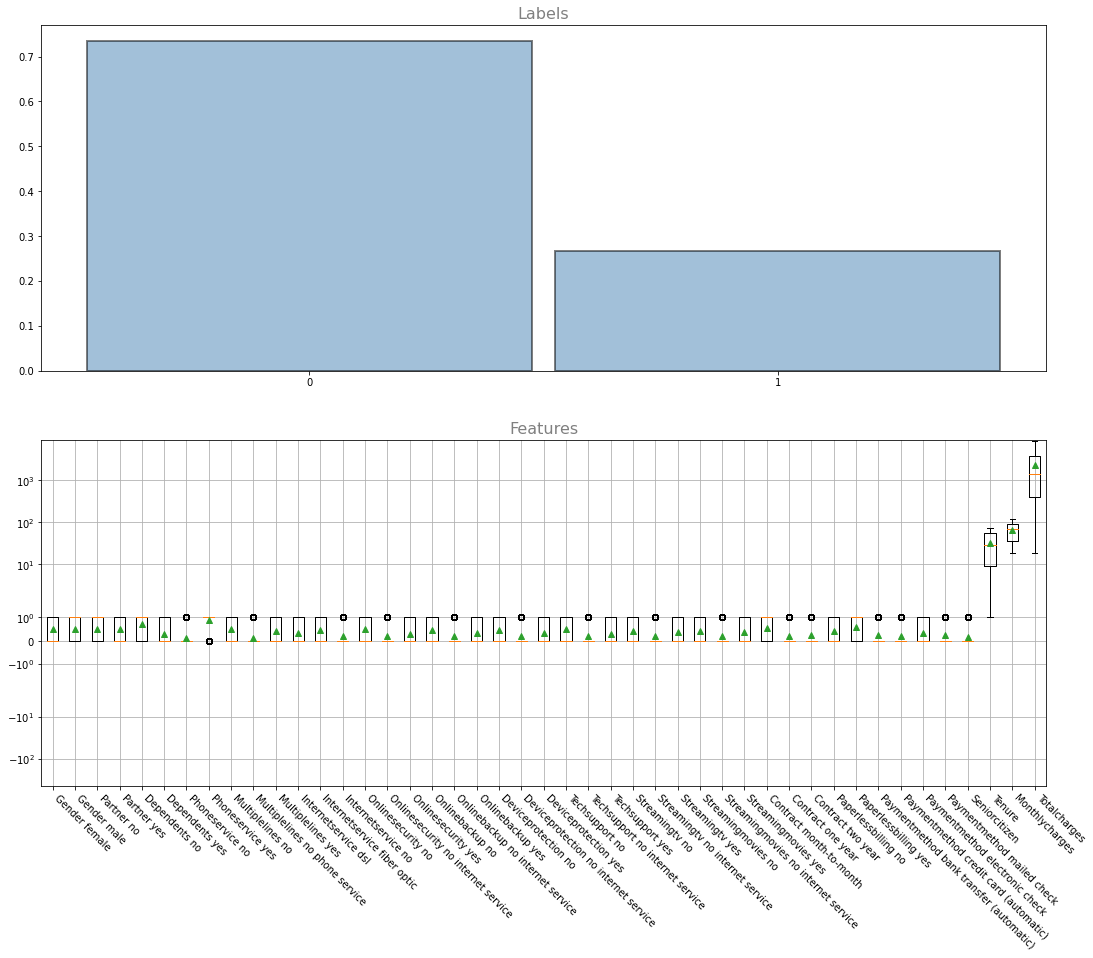

In [11]:
fig = plt.figure(figsize=(18., 14.))
#
ax = plt.subplot(2, 1, 1)
ax.set_title("Labels", fontsize=16, color="gray")
ax.hist(labels_array, bins=[-0.5, 0.5, 1.5], rwidth=0.95, align="mid", density=True,
        edgecolor="black", color="steelblue", alpha=0.5, lw=2.0)
ax.set_xticks([0, 1])
#
ax = plt.subplot(2, 1, 2)
ax.set_title("Features", fontsize=16, color="gray")
ax.boxplot(features_array, showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
                   ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("symlog")
#
plt.show()

<br><br><br>

# Prepare Data

## Shuffle

In [12]:
# Create a shuffle mask
shuffle_mask = np.arange(dataset_size)
np.random.shuffle(shuffle_mask)

features_array = features_array[shuffle_mask]
labels_array = labels_array[shuffle_mask]

## Split

In [13]:
test_set_fraction = 0.2

split_mask = np.where(np.random.sample(dataset_size) >= test_set_fraction, True, False)
x_train = features_array[split_mask]
y_train = labels_array[split_mask]
x_test = features_array[np.logical_not(split_mask)]
y_test = labels_array[np.logical_not(split_mask)]

print(f"\t Train set features: {x_train.shape}")
print(f"\t Train set labels:   {y_train.shape}")
print(f"\t Test set features:  {x_test.shape}")
print(f"\t Test set labels:    {y_test.shape}")

	 Train set features: (5599, 45)
	 Train set labels:   (5599,)
	 Test set features:  (1433, 45)
	 Test set labels:    (1433,)


## Normalize:

In [14]:
x_train_means = np.mean(x_train, axis=0)
x_train_stds = np.std(x_train, axis=0)

def normalize_input(x, means=x_train_means, stds=x_train_stds):
    """Normalize the input features.
    """
    means = means[np.newaxis,:]
    stds = stds[np.newaxis,:]
    x = x - means
    return np.divide(x, stds, out=np.zeros_like(x), where=(stds != 0))

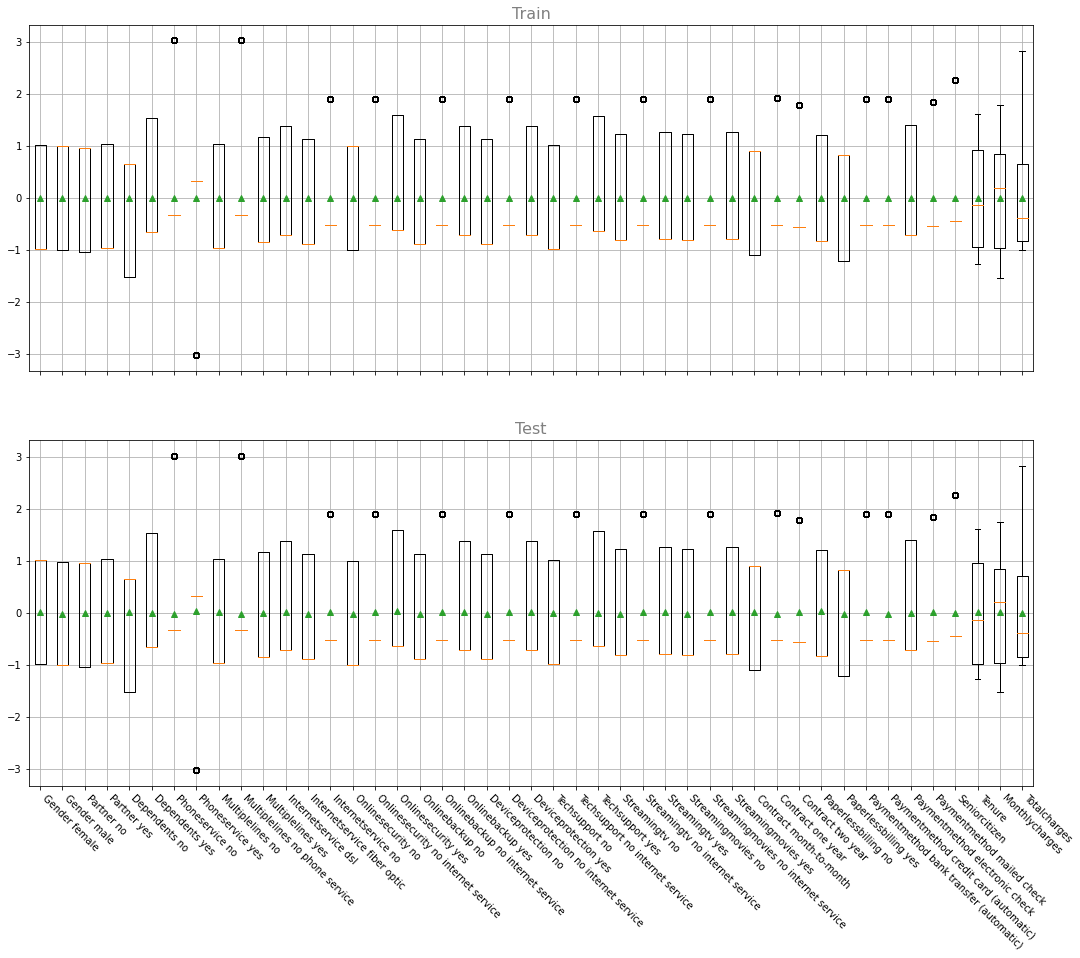

In [15]:
fig = plt.figure(figsize=(18., 14.))
#
ax = plt.subplot(2, 1, 1)
ax.set_title("Train", fontsize=16, color="gray")
ax.boxplot(normalize_input(x_train), showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([])
# ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
#                    ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("linear")
#
ax = plt.subplot(2, 1, 2)
ax.set_title("Test", fontsize=16, color="gray")
ax.boxplot(normalize_input(x_test), showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
                   ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("linear")
#
plt.show()

<br><br><br>

# Predict Customer Churn

## Utilities

In [16]:
class SparseCategoricalTP(tf.keras.metrics.TruePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(tf.math.argmax(y_pred, axis=-1))
        super(SparseCategoricalTP, self).update_state(y_true, y_pred, sample_weight)

class SparseCategoricalFN(tf.keras.metrics.FalseNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(tf.math.argmax(y_pred, axis=-1))
        super(SparseCategoricalFN, self).update_state(y_true, y_pred, sample_weight)

class SparseCategoricalFP(tf.keras.metrics.FalsePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(tf.math.argmax(y_pred, axis=-1))
        super(SparseCategoricalFP, self).update_state(y_true, y_pred, sample_weight)

class SparseCategoricalTN(tf.keras.metrics.TrueNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(tf.math.argmax(y_pred, axis=-1))
        super(SparseCategoricalTN, self).update_state(y_true, y_pred, sample_weight)

In [17]:
def plot_confusion_matrix(conf_mat: np.ndarray):
    conf_mat = conf_mat / np.sum(conf_mat)
    plt.title("Confusion Matrix", color="gray", fontsize=18)
    plt.imshow(conf_mat, cmap="Blues")
    ax = plt.gca()
    ax.set_xlabel("Prediction", color="gray", fontsize=14)
    ax.set_ylabel("Condition", color="gray", fontsize=14)
    ax.text(0.0, 0.0, "TN\n" + str(round(conf_mat[0, 0], 2)), 
            ha="center", va="center", color="royalblue", fontsize=18, transform=ax.transData)
    ax.text(1.0, 0.0, "FP\n" + str(round(conf_mat[0, 1], 2)), 
            ha="center", va="center", color="orange", fontsize=18, transform=ax.transData)
    ax.text(0.0, 1.0, "FN\n" + str(round(conf_mat[1, 0], 2)), 
            ha="center", va="center", color="orange", fontsize=18, transform=ax.transData)
    ax.text(1.0, 1.0, "TP\n" + str(round(conf_mat[1, 1], 2)), 
            ha="center", va="center", color="royalblue", fontsize=18, transform=ax.transData)
    ax.set_xlabel("Prediction", color="gray", fontsize=14)
    ax.set_ylabel("Condition", color="gray", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [18]:
def evaluate_model(model, features, labels, show_confusion_matrix=True):
    eval_results = model.evaluate(
    features, labels, return_dict=True, verbose=0)

    # print("Evaluation results:")
    for name, val in eval_results.items():
        print(f"\t{name:32}{round(float(val), 5)}")
    
    if show_confusion_matrix:
        conf_mat = np.array([
            [eval_results["TN"], eval_results["FP"]],
            [eval_results["FN"], eval_results["TP"]]])
        plot_confusion_matrix(conf_mat)

## Logistic Regression

Let's first use logistic regression to establish a baseline for comparisons. 

Instead of using other Python libraries such as SciKit Learn (sklearn), I use TensorFlow.

In [19]:
inputs = tf.keras.Input(
    shape=(len(feature_names),),
    name="input")
outputs = tf.keras.layers.Dense(
    2, 
    activation=tf.keras.activations.softmax,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    name="output"
)(inputs)

logistic_regression_model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs,
    name="boston_house_appraiser")

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    SparseCategoricalTP(thresholds=None, name="TP"),
    SparseCategoricalFN(thresholds=None, name="FN"),
    SparseCategoricalFP(thresholds=None, name="FP"),
    SparseCategoricalTN(thresholds=None, name="TN")]

logistic_regression_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [21]:
# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", 
    min_delta=0.05, 
    patience=100, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

fit_history = logistic_regression_model.fit(
    x=normalize_input(x_train), 
    y=y_train,
    batch_size=128,
    epochs=1000,
    verbose=0,
    validation_split=0.0,
    shuffle=True,
    class_weight={0: 1.0, 1: 3.0},  # To compensate for class imbalance
    workers=8,
    callbacks=[early_stopping_callback])

Restoring model weights from the end of the best epoch.
Epoch 00174: early stopping


	loss                            0.53429
	accuracy                        0.72784
	TP                              308.0
	FN                              64.0
	FP                              326.0
	TN                              735.0


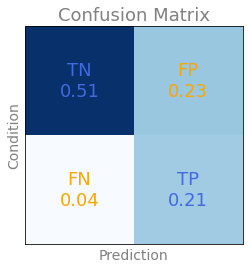

In [22]:
evaluate_model(
    model=logistic_regression_model, 
    features=normalize_input(x_test), 
    labels=y_test)

<br><br><br>

## DNN Classifier Model

Next, we construct a DNN for predicting customer churn.

### Construct Model

In [39]:
inputs = tf.keras.Input(
    shape=(len(feature_names),),
    name="input")
x = tf.keras.layers.Dense(
    64, 
    activation=tf.keras.activations.tanh,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=tf.keras.regularizers.L1(l1=0.1),
    bias_regularizer=None,
    name="dense_1"
)(inputs)
# x = tf.keras.layers.Dropout(rate=0.2, name="dropout_1")(x)
x = tf.keras.layers.Dense(
    32, 
    activation=tf.keras.activations.tanh,
    use_bias=False, #True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None, #tf.keras.regularizers.L2(l2=0.01),
    bias_regularizer=None,
    name="dense_2"
)(x)
x = tf.keras.layers.Dropout(rate=0.2, name="dropout_2")(x)
outputs = tf.keras.layers.Dense(
    2, 
    activation=tf.keras.activations.softmax,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None, #tf.keras.regularizers.L2(l2=0.0001),
    bias_regularizer=None,
    name="output"
)(x)

model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs,
    name="boston_house_appraiser")

model.summary(print_fn=(lambda *x: print("\t", *x)))

	 Model: "boston_house_appraiser"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input (InputLayer)           [(None, 45)]              0         
	 _________________________________________________________________
	 dense_1 (Dense)              (None, 64)                2944      
	 _________________________________________________________________
	 dense_2 (Dense)              (None, 32)                2048      
	 _________________________________________________________________
	 dropout_2 (Dropout)          (None, 32)                0         
	 _________________________________________________________________
	 output (Dense)               (None, 2)                 66        
	 Total params: 5,058
	 Trainable params: 5,058
	 Non-trainable params: 0
	 _________________________________________________________________


### Compile

In [40]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
    epsilon=1e-07, amsgrad=False, name="Adam")

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    SparseCategoricalTP(thresholds=None, name="TP"),
    SparseCategoricalFN(thresholds=None, name="FN"),
    SparseCategoricalFP(thresholds=None, name="FP"),
    SparseCategoricalTN(thresholds=None, name="TN")]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Fit Model

In [41]:
# Learning rate schedule
def lr_schedule(epoch, lr):
    if (epoch < 10): return lr
    else: return 1.0 * lr
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lr_schedule, 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.05, 
    patience=200, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

# Fit model
fit_history = model.fit(
    x=normalize_input(x_train), 
    y=y_train,
    batch_size=128,
    epochs=4000,
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    class_weight={0: 1.0, 1: 3.0},  # To compensate for class imbalance
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

evaluate_model(
    model=model, 
    features=normalize_input(x_train), 
    labels=y_train,
    show_confusion_matrix=False)

Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping
	loss                            0.57469
	accuracy                        0.75013
	TP                              1207.0
	FN                              290.0
	FP                              1109.0
	TN                              2993.0


### Training History

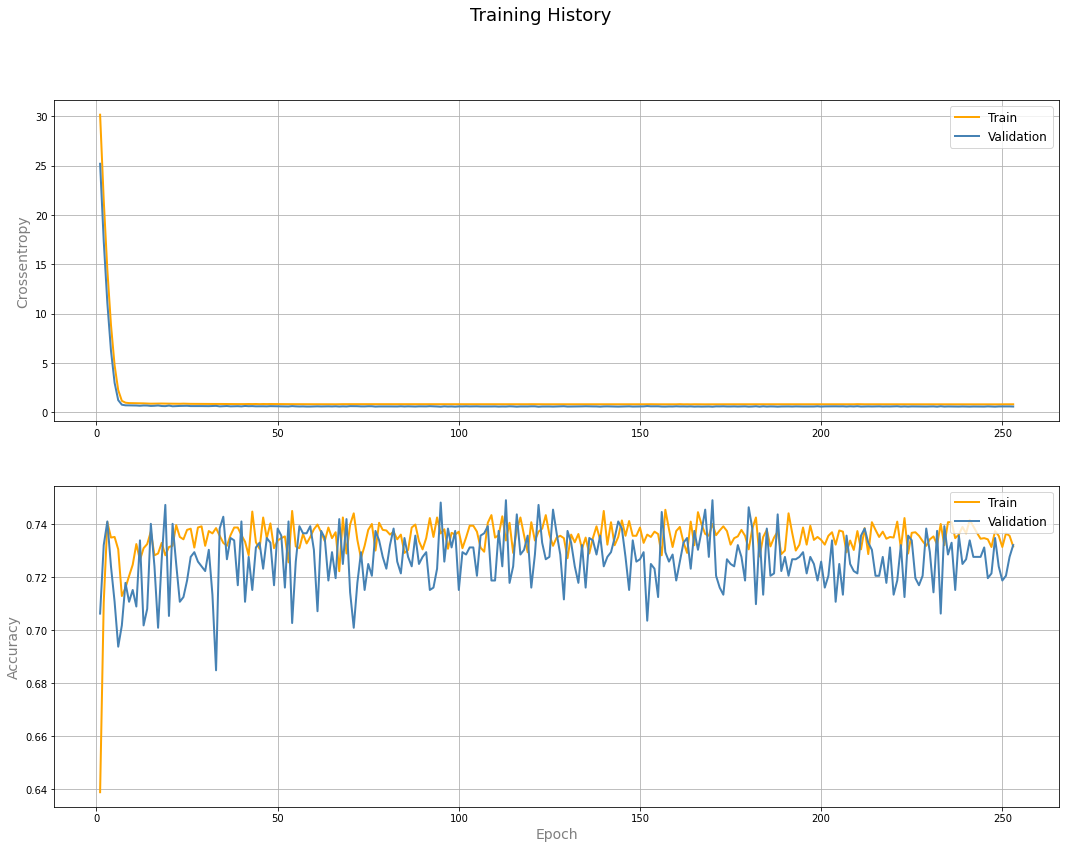

In [42]:
train_losses = fit_history.history["loss"]
val_losses = fit_history.history["val_loss"]
train_rms = fit_history.history["accuracy"]
val_rms = fit_history.history["val_accuracy"]
num_epochs = len(train_losses)
epochs = np.linspace(start=1, stop=num_epochs, num=num_epochs, endpoint=True)

fig = plt.figure(figsize=(18., 13.))
plt.suptitle("Training History", fontsize=18)
#
ax1 = plt.subplot(2, 1, 1)
# ax1.set_title("MSE", fontsize=18)
# ax1.set_xlabel("Epoch", fontsize=14., color="gray")
ax1.set_ylabel("Crossentropy", fontsize=14., color="gray")
ax1.plot(epochs, train_losses, marker="", lw=2.0, color="orange", label="Train")
ax1.plot(epochs, val_losses, marker="", lw=2.0, color="steelblue", label="Validation")
# ax1.set_ylim(-10.0, 100.0)
ax1.grid()
ax1.set_axisbelow(True)
ax1.legend(loc="upper right", fontsize=12)
#
ax2 = plt.subplot(2, 1, 2)
# ax2.set_title("RMS", fontsize=18)
ax2.set_xlabel("Epoch", fontsize=14., color="gray")
ax2.set_ylabel("Accuracy", fontsize=14., color="gray")
ax2.plot(epochs, train_rms, marker="", lw=2.0, color="orange", label="Train")
ax2.plot(epochs, val_rms, marker="", lw=2.0, color="steelblue", label="Validation")
# ax2.set_ylim(-1.0, 20.0)
ax2.grid()
ax2.set_axisbelow(True)
ax2.legend(loc="upper right", fontsize=12)
#
plt.show()

### Model Evaluation

	loss                            0.56967
	accuracy                        0.7432
	TP                              304.0
	FN                              68.0
	FP                              300.0
	TN                              761.0


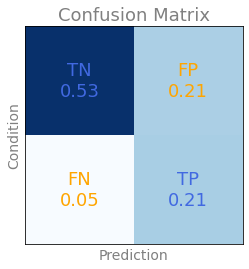

In [43]:
evaluate_model(
    model=model, 
    features=normalize_input(x_test), 
    labels=y_test)